In [1]:
# modelagem e dados
import torch
from torch import nn, optim

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt

# operações de imagem
import cv2

# outros
import os
import numpy as np
from tqdm import tqdm

In [2]:
from model.model_encoder_deconv import SegNet, transforms
from dataset.dataloader import train_loader, val_loader, test_loader


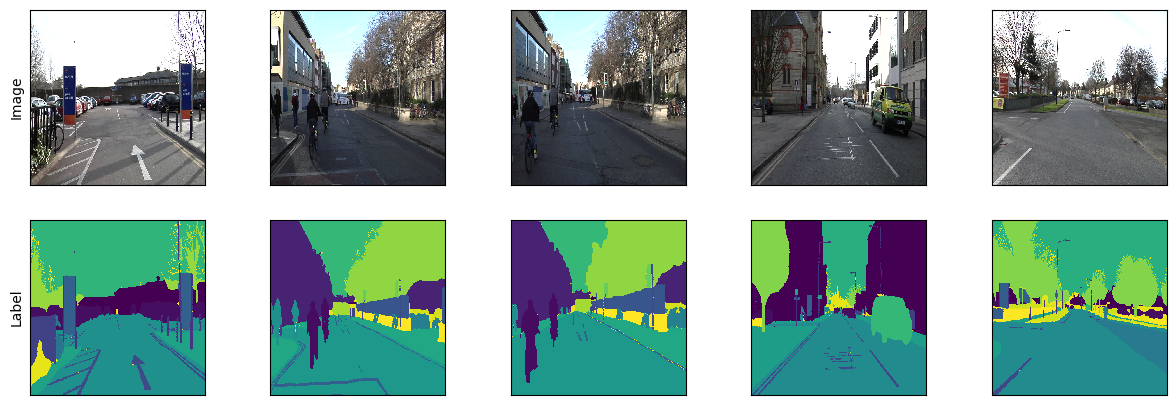

In [3]:
w = 5
fig, ax = plt.subplots(2, w, figsize=(15, 5))

ax[0][0].set_ylabel("Image")
ax[1][0].set_ylabel("Label")

for j in range(w):
    instances, targets = next(iter(train_loader))
    ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
model = SegNet().to(device)
model.load_state_dict(torch.load(r"model\weights\best_pretrained_deconv_whole_road.zip"))
summary(SegNet().to(device), (3, 224, 224), 1, device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
            Conv2d-2          [1, 64, 224, 224]           1,792
              ReLU-3          [1, 64, 224, 224]               0
       BatchNorm2d-4          [1, 64, 224, 224]             128
            Conv2d-5          [1, 64, 224, 224]          36,928
            Conv2d-6          [1, 64, 224, 224]          36,928
              ReLU-7          [1, 64, 224, 224]               0
       BatchNorm2d-8          [1, 64, 224, 224]             128
         MaxPool2d-9          [1, 64, 112, 112]               0
           Conv2d-10         [1, 128, 112, 112]          73,856
           Conv2d-11         [1, 128, 112, 112]          73,856
             ReLU-12         [1, 128, 112, 112]               0
      BatchNorm2d-13         [1, 128, 112, 112]             256
           Conv2d-14         [1, 128, 1

In [34]:
train_losses = list()
valid_losses = list()

In [35]:
EPOCHS = 100
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [36]:
def train_step(model, loader, loss_fn, optimizer, device) -> float:
  train_loss = 0
  for X, Y in loader:
    X = transforms(X)
    y_pred = model(X.to(device))
    loss = loss_fn(y_pred, Y.to(device))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  return train_loss / len(loader)


def validation_step(model, loader, loss_fn, device) -> float:
  loss = 0
  with torch.no_grad():
    for X, Y in loader:
      X = transforms(X)
      y_pred = model(X.to(device))
      loss += loss_fn(y_pred, Y.to(device)).item()
  return loss / len(loader)

In [37]:
from tqdm import tqdm
from copy import deepcopy

def train_model():
  for epoch in tqdm(range(EPOCHS)):
    train_losses.append(train_step(model, train_loader, loss_fn, optimizer, device))
    valid_losses.append(validation_step(model, val_loader, loss_fn, device))
    if valid_losses[-1] == min(valid_losses):
      best_model = deepcopy(model)
    print("Loss: {:.5f}".format(valid_losses[-1]), end="\f\f")
  return best_model

In [38]:
model.freeze_encoder_block()
best_model = train_model()

  1%|          | 1/100 [00:52<1:26:42, 52.55s/it]

Loss: 2.72032

  2%|▏         | 2/100 [01:45<1:25:47, 52.52s/it]

Loss: 2.71614

  3%|▎         | 3/100 [02:37<1:25:00, 52.58s/it]

Loss: 2.71397

  4%|▍         | 4/100 [03:30<1:24:13, 52.64s/it]

Loss: 2.69648

  5%|▌         | 5/100 [04:23<1:23:23, 52.66s/it]

Loss: 2.68263

  6%|▌         | 6/100 [05:15<1:22:26, 52.62s/it]

Loss: 2.67411

  7%|▋         | 7/100 [06:08<1:21:30, 52.58s/it]

Loss: 2.66836

  8%|▊         | 8/100 [07:00<1:20:35, 52.56s/it]

Loss: 2.66470

  9%|▉         | 9/100 [07:53<1:19:41, 52.54s/it]

Loss: 2.66280

 10%|█         | 10/100 [08:45<1:18:53, 52.60s/it]

Loss: 2.66133

 11%|█         | 11/100 [09:38<1:18:04, 52.64s/it]

Loss: 2.65607

 12%|█▏        | 12/100 [10:31<1:17:10, 52.62s/it]

Loss: 2.64665

 13%|█▎        | 13/100 [11:23<1:16:14, 52.58s/it]

Loss: 2.64109

 14%|█▍        | 14/100 [12:16<1:15:18, 52.54s/it]

Loss: 2.63767

 15%|█▌        | 15/100 [13:08<1:14:30, 52.59s/it]

Loss: 2.63484

 16%|█▌        | 16/100 [14:01<1:13:37, 52.59s/it]

Loss: 2.63056

 17%|█▋        | 17/100 [14:53<1:12:41, 52.54s/it]

Loss: 2.62861

 18%|█▊        | 18/100 [15:46<1:11:45, 52.51s/it]

Loss: 2.62725

 19%|█▉        | 19/100 [16:38<1:10:51, 52.48s/it]

Loss: 2.62765

 20%|██        | 20/100 [17:31<1:09:59, 52.50s/it]

Loss: 2.62750

 21%|██        | 21/100 [18:23<1:09:05, 52.48s/it]

Loss: 2.62141

 22%|██▏       | 22/100 [19:16<1:08:11, 52.45s/it]

Loss: 2.61760

 23%|██▎       | 23/100 [20:08<1:07:17, 52.43s/it]

Loss: 2.61735

 24%|██▍       | 24/100 [21:01<1:06:29, 52.50s/it]

Loss: 2.62080

 25%|██▌       | 25/100 [21:53<1:05:42, 52.56s/it]

Loss: 2.62554

 26%|██▌       | 26/100 [22:50<1:06:19, 53.78s/it]

Loss: 2.62450

 27%|██▋       | 27/100 [24:11<1:15:24, 61.98s/it]

Loss: 2.62117

 28%|██▊       | 28/100 [25:32<1:21:14, 67.70s/it]

Loss: 2.62024

 29%|██▉       | 29/100 [26:52<1:24:34, 71.48s/it]

Loss: 2.62493

 30%|███       | 30/100 [28:13<1:26:34, 74.21s/it]

Loss: 2.63010

 31%|███       | 31/100 [29:34<1:27:37, 76.19s/it]

Loss: 2.63023

 32%|███▏      | 32/100 [30:54<1:27:37, 77.31s/it]

Loss: 2.62651

 33%|███▎      | 33/100 [32:15<1:27:30, 78.37s/it]

Loss: 2.62027

 34%|███▍      | 34/100 [33:35<1:26:50, 78.95s/it]

Loss: 2.61681

 35%|███▌      | 35/100 [34:55<1:26:03, 79.43s/it]

Loss: 2.61803

 36%|███▌      | 36/100 [36:16<1:25:06, 79.78s/it]

Loss: 2.62125

 37%|███▋      | 37/100 [37:37<1:24:01, 80.03s/it]

Loss: 2.62267

 38%|███▊      | 38/100 [38:57<1:22:39, 79.99s/it]

Loss: 2.62142

 39%|███▉      | 39/100 [40:17<1:21:29, 80.16s/it]

Loss: 2.61566

 40%|████      | 40/100 [41:37<1:20:10, 80.18s/it]

Loss: 2.61201

 41%|████      | 41/100 [42:58<1:18:55, 80.26s/it]

Loss: 2.61170

 42%|████▏     | 42/100 [44:18<1:17:42, 80.39s/it]

Loss: 2.61469

 43%|████▎     | 43/100 [45:39<1:16:21, 80.38s/it]

Loss: 2.62144

 44%|████▍     | 44/100 [46:59<1:15:02, 80.40s/it]

Loss: 2.62312

 45%|████▌     | 45/100 [48:19<1:13:37, 80.32s/it]

Loss: 2.61902

 46%|████▌     | 46/100 [49:40<1:12:13, 80.26s/it]

Loss: 2.61180

 47%|████▋     | 47/100 [51:00<1:10:56, 80.32s/it]

Loss: 2.60710

 48%|████▊     | 48/100 [52:20<1:09:38, 80.35s/it]

Loss: 2.60627

 49%|████▉     | 49/100 [53:41<1:08:19, 80.37s/it]

Loss: 2.60660

 50%|█████     | 50/100 [55:01<1:07:01, 80.44s/it]

Loss: 2.61062

 51%|█████     | 51/100 [56:22<1:05:44, 80.50s/it]

Loss: 2.61387

 52%|█████▏    | 52/100 [57:42<1:04:21, 80.45s/it]

Loss: 2.61372

 53%|█████▎    | 53/100 [59:03<1:02:59, 80.42s/it]

Loss: 2.61183

 54%|█████▍    | 54/100 [1:00:24<1:01:44, 80.54s/it]

Loss: 2.61009

 55%|█████▌    | 55/100 [1:01:43<1:00:13, 80.30s/it]

Loss: 2.60926

 56%|█████▌    | 56/100 [1:03:04<58:59, 80.44s/it]  

Loss: 2.60887

 57%|█████▋    | 57/100 [1:04:25<57:40, 80.48s/it]

Loss: 2.60878

 58%|█████▊    | 58/100 [1:05:45<56:21, 80.50s/it]

Loss: 2.60895

 59%|█████▉    | 59/100 [1:07:06<55:04, 80.59s/it]

Loss: 2.60958

 60%|██████    | 60/100 [1:08:26<53:39, 80.48s/it]

Loss: 2.61040

 61%|██████    | 61/100 [1:09:46<52:14, 80.36s/it]

Loss: 2.61063

 62%|██████▏   | 62/100 [1:11:07<50:57, 80.45s/it]

Loss: 2.60947

 63%|██████▎   | 63/100 [1:12:27<49:33, 80.37s/it]

Loss: 2.60768

 64%|██████▍   | 64/100 [1:13:47<48:10, 80.30s/it]

Loss: 2.60556

 65%|██████▌   | 65/100 [1:15:07<46:49, 80.27s/it]

Loss: 2.60425

 66%|██████▌   | 66/100 [1:16:28<45:29, 80.27s/it]

Loss: 2.60431

 67%|██████▋   | 67/100 [1:17:48<44:12, 80.38s/it]

Loss: 2.60573

 68%|██████▊   | 68/100 [1:19:09<42:55, 80.49s/it]

Loss: 2.60705

 69%|██████▉   | 69/100 [1:20:30<41:34, 80.47s/it]

Loss: 2.60663

 70%|███████   | 70/100 [1:21:50<40:16, 80.55s/it]

Loss: 2.60324

 71%|███████   | 71/100 [1:23:11<38:56, 80.57s/it]

Loss: 2.60093

 72%|███████▏  | 72/100 [1:24:31<37:32, 80.43s/it]

Loss: 2.60064

 73%|███████▎  | 73/100 [1:25:51<36:10, 80.39s/it]

Loss: 2.60089

 74%|███████▍  | 74/100 [1:27:12<34:51, 80.44s/it]

Loss: 2.60293

 75%|███████▌  | 75/100 [1:28:32<33:28, 80.35s/it]

Loss: 2.60722

 76%|███████▌  | 76/100 [1:29:52<32:07, 80.30s/it]

Loss: 2.60817

 77%|███████▋  | 77/100 [1:31:12<30:45, 80.24s/it]

Loss: 2.60695

 78%|███████▊  | 78/100 [1:32:33<29:28, 80.37s/it]

Loss: 2.60309

 79%|███████▉  | 79/100 [1:33:53<28:07, 80.34s/it]

Loss: 2.60081

 80%|████████  | 80/100 [1:35:14<26:48, 80.43s/it]

Loss: 2.60104

 81%|████████  | 81/100 [1:36:34<25:27, 80.42s/it]

Loss: 2.60253

 82%|████████▏ | 82/100 [1:37:55<24:09, 80.50s/it]

Loss: 2.60650

 83%|████████▎ | 83/100 [1:39:16<22:49, 80.56s/it]

Loss: 2.60862

 84%|████████▍ | 84/100 [1:40:36<21:29, 80.58s/it]

Loss: 2.60897

 85%|████████▌ | 85/100 [1:41:57<20:09, 80.60s/it]

Loss: 2.60742

 86%|████████▌ | 86/100 [1:43:17<18:47, 80.52s/it]

Loss: 2.60368

 87%|████████▋ | 87/100 [1:44:37<17:25, 80.41s/it]

Loss: 2.60006

 88%|████████▊ | 88/100 [1:45:58<16:04, 80.41s/it]

Loss: 2.59935

 89%|████████▉ | 89/100 [1:47:18<14:44, 80.41s/it]

Loss: 2.60225

 90%|█████████ | 90/100 [1:48:39<13:24, 80.44s/it]

Loss: 2.60622

 91%|█████████ | 91/100 [1:49:59<12:03, 80.43s/it]

Loss: 2.60759

 92%|█████████▏| 92/100 [1:51:20<10:44, 80.51s/it]

Loss: 2.60626

 93%|█████████▎| 93/100 [1:52:40<09:23, 80.55s/it]

Loss: 2.60270

 94%|█████████▍| 94/100 [1:54:00<08:02, 80.38s/it]

Loss: 2.59814

 95%|█████████▌| 95/100 [1:55:21<06:41, 80.35s/it]

Loss: 2.59741

 96%|█████████▌| 96/100 [1:56:42<05:21, 80.50s/it]

Loss: 2.59887

 97%|█████████▋| 97/100 [1:58:02<04:01, 80.38s/it]

Loss: 2.60322

 98%|█████████▊| 98/100 [1:59:22<02:40, 80.50s/it]

Loss: 2.60597

 99%|█████████▉| 99/100 [2:00:42<01:20, 80.36s/it]

Loss: 2.60687

100%|██████████| 100/100 [2:02:03<00:00, 73.23s/it]

Loss: 2.60544

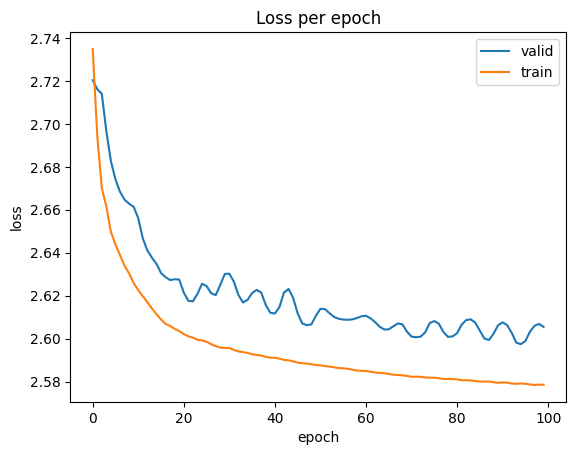

In [39]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

In [40]:
model.unfreeze_encoder_block()
best_model = train_model()

  1%|          | 1/100 [01:21<2:13:58, 81.19s/it]

Loss: 2.60333

  2%|▏         | 2/100 [02:41<2:11:52, 80.74s/it]

Loss: 2.60145

  3%|▎         | 3/100 [04:01<2:10:10, 80.52s/it]

Loss: 2.60040

  4%|▍         | 4/100 [05:22<2:08:52, 80.54s/it]

Loss: 2.60150

  5%|▌         | 5/100 [06:43<2:07:38, 80.62s/it]

Loss: 2.60339

  6%|▌         | 6/100 [08:03<2:05:53, 80.36s/it]

Loss: 2.60490

  7%|▋         | 7/100 [09:23<2:04:41, 80.44s/it]

Loss: 2.60625

  8%|▊         | 8/100 [10:43<2:03:15, 80.38s/it]

Loss: 2.60621

  9%|▉         | 9/100 [12:04<2:01:51, 80.34s/it]

Loss: 2.60408

 10%|█         | 10/100 [13:24<2:00:26, 80.29s/it]

Loss: 2.60042

 11%|█         | 11/100 [14:44<1:59:06, 80.29s/it]

Loss: 2.59754

 12%|█▏        | 12/100 [16:05<1:57:55, 80.40s/it]

Loss: 2.59743

 13%|█▎        | 13/100 [17:25<1:56:29, 80.34s/it]

Loss: 2.60014

 14%|█▍        | 14/100 [18:45<1:55:12, 80.38s/it]

Loss: 2.60394

 15%|█▌        | 15/100 [20:06<1:53:52, 80.38s/it]

Loss: 2.60624

 16%|█▌        | 16/100 [21:27<1:52:41, 80.49s/it]

Loss: 2.60701

 17%|█▋        | 17/100 [22:47<1:51:14, 80.41s/it]

Loss: 2.60632

 18%|█▊        | 18/100 [24:07<1:49:48, 80.34s/it]

Loss: 2.60490

 19%|█▉        | 19/100 [25:28<1:48:36, 80.45s/it]

Loss: 2.60338

 20%|██        | 20/100 [26:48<1:47:20, 80.50s/it]

Loss: 2.60217

 21%|██        | 21/100 [28:09<1:45:55, 80.45s/it]

Loss: 2.60201

 22%|██▏       | 22/100 [29:30<1:44:47, 80.61s/it]

Loss: 2.60352

 23%|██▎       | 23/100 [30:50<1:43:13, 80.43s/it]

Loss: 2.60563

 24%|██▍       | 24/100 [32:10<1:41:56, 80.49s/it]

Loss: 2.60709

 25%|██▌       | 25/100 [33:31<1:40:32, 80.44s/it]

Loss: 2.60742

 26%|██▌       | 26/100 [34:51<1:39:11, 80.42s/it]

Loss: 2.60659

 27%|██▋       | 27/100 [36:11<1:37:45, 80.35s/it]

Loss: 2.60482

 28%|██▊       | 28/100 [37:31<1:36:19, 80.27s/it]

Loss: 2.60227

 29%|██▉       | 29/100 [38:51<1:34:58, 80.26s/it]

Loss: 2.60067

 30%|███       | 30/100 [40:12<1:33:40, 80.29s/it]

Loss: 2.60189

 31%|███       | 31/100 [41:32<1:32:26, 80.38s/it]

Loss: 2.60422

 32%|███▏      | 32/100 [42:53<1:31:02, 80.33s/it]

Loss: 2.60610

 33%|███▎      | 33/100 [44:13<1:29:42, 80.34s/it]

Loss: 2.60660

 34%|███▍      | 34/100 [45:33<1:28:22, 80.34s/it]

Loss: 2.60566

 35%|███▌      | 35/100 [46:54<1:27:02, 80.35s/it]

Loss: 2.60416

 36%|███▌      | 36/100 [48:14<1:25:39, 80.30s/it]

Loss: 2.60281

 37%|███▋      | 37/100 [49:34<1:24:13, 80.21s/it]

Loss: 2.60186

 38%|███▊      | 38/100 [50:54<1:22:50, 80.16s/it]

Loss: 2.60152

 39%|███▉      | 39/100 [52:14<1:21:32, 80.20s/it]

Loss: 2.60192

 40%|████      | 40/100 [53:35<1:20:15, 80.25s/it]

Loss: 2.60294

 41%|████      | 41/100 [54:55<1:18:58, 80.32s/it]

Loss: 2.60438

 42%|████▏     | 42/100 [56:16<1:17:50, 80.53s/it]

Loss: 2.60574

 43%|████▎     | 43/100 [57:37<1:16:27, 80.48s/it]

Loss: 2.60640

 44%|████▍     | 44/100 [58:57<1:15:02, 80.39s/it]

Loss: 2.60576

 45%|████▌     | 45/100 [1:00:17<1:13:39, 80.36s/it]

Loss: 2.60413

 46%|████▌     | 46/100 [1:01:37<1:12:20, 80.39s/it]

Loss: 2.60217

 47%|████▋     | 47/100 [1:02:57<1:10:52, 80.24s/it]

Loss: 2.60095

 48%|████▊     | 48/100 [1:04:18<1:09:40, 80.40s/it]

Loss: 2.60121

 49%|████▉     | 49/100 [1:05:39<1:08:23, 80.47s/it]

Loss: 2.60269

 50%|█████     | 50/100 [1:06:59<1:06:58, 80.36s/it]

Loss: 2.60430

 51%|█████     | 51/100 [1:08:19<1:05:41, 80.43s/it]

Loss: 2.60564

 52%|█████▏    | 52/100 [1:09:40<1:04:17, 80.36s/it]

Loss: 2.60611

 53%|█████▎    | 53/100 [1:11:00<1:02:59, 80.41s/it]

Loss: 2.60596

 54%|█████▍    | 54/100 [1:12:23<1:02:09, 81.07s/it]

Loss: 2.60636

 55%|█████▌    | 55/100 [1:13:49<1:01:52, 82.51s/it]

Loss: 2.60565

 56%|█████▌    | 56/100 [1:15:09<59:57, 81.77s/it]  

Loss: 2.60299

 57%|█████▋    | 57/100 [1:16:29<58:18, 81.36s/it]

Loss: 2.60155

 58%|█████▊    | 58/100 [1:17:50<56:47, 81.14s/it]

Loss: 2.60184

 59%|█████▉    | 59/100 [1:19:10<55:17, 80.92s/it]

Loss: 2.60348

 60%|██████    | 60/100 [1:20:30<53:45, 80.63s/it]

Loss: 2.60525

 61%|██████    | 61/100 [1:21:50<52:17, 80.44s/it]

Loss: 2.60679

 62%|██████▏   | 62/100 [1:23:11<50:56, 80.45s/it]

Loss: 2.60695

 63%|██████▎   | 63/100 [1:24:31<49:35, 80.43s/it]

Loss: 2.60634

 64%|██████▍   | 64/100 [1:25:51<48:16, 80.47s/it]

Loss: 2.60494

 65%|██████▌   | 65/100 [1:27:12<46:56, 80.46s/it]

Loss: 2.60278

 66%|██████▌   | 66/100 [1:28:32<45:34, 80.44s/it]

Loss: 2.60066

 67%|██████▋   | 67/100 [1:29:53<44:13, 80.42s/it]

Loss: 2.59903

 68%|██████▊   | 68/100 [1:31:13<42:51, 80.35s/it]

Loss: 2.59866

 69%|██████▉   | 69/100 [1:32:33<41:28, 80.26s/it]

Loss: 2.60011

 70%|███████   | 70/100 [1:33:53<40:05, 80.20s/it]

Loss: 2.60311

 71%|███████   | 71/100 [1:35:13<38:44, 80.17s/it]

Loss: 2.60638

 72%|███████▏  | 72/100 [1:36:33<37:24, 80.17s/it]

Loss: 2.60699

 73%|███████▎  | 73/100 [1:37:54<36:06, 80.23s/it]

Loss: 2.60645

 74%|███████▍  | 74/100 [1:39:14<34:47, 80.27s/it]

Loss: 2.60481

 75%|███████▌  | 75/100 [1:40:34<33:27, 80.30s/it]

Loss: 2.60296

 76%|███████▌  | 76/100 [1:41:55<32:07, 80.30s/it]

Loss: 2.60071

 77%|███████▋  | 77/100 [1:43:15<30:48, 80.37s/it]

Loss: 2.59881

 78%|███████▊  | 78/100 [1:44:35<29:26, 80.30s/it]

Loss: 2.59874

 79%|███████▉  | 79/100 [1:45:55<28:05, 80.25s/it]

Loss: 2.60097

 80%|████████  | 80/100 [1:47:16<26:46, 80.34s/it]

Loss: 2.60499

 81%|████████  | 81/100 [1:48:36<25:27, 80.37s/it]

Loss: 2.60673

 82%|████████▏ | 82/100 [1:49:56<24:04, 80.26s/it]

Loss: 2.60591

 83%|████████▎ | 83/100 [1:51:17<22:44, 80.25s/it]

Loss: 2.60364

 84%|████████▍ | 84/100 [1:52:37<21:23, 80.24s/it]

Loss: 2.60231

 85%|████████▌ | 85/100 [1:53:57<20:03, 80.23s/it]

Loss: 2.60298

 86%|████████▌ | 86/100 [1:55:17<18:43, 80.27s/it]

Loss: 2.60311

 87%|████████▋ | 87/100 [1:56:38<17:24, 80.37s/it]

Loss: 2.60253

 88%|████████▊ | 88/100 [1:57:58<16:04, 80.37s/it]

Loss: 2.60273

 89%|████████▉ | 89/100 [1:59:19<14:44, 80.42s/it]

Loss: 2.60372

 90%|█████████ | 90/100 [2:00:40<13:24, 80.49s/it]

Loss: 2.60561

 91%|█████████ | 91/100 [2:02:00<12:03, 80.43s/it]

Loss: 2.60714

 92%|█████████▏| 92/100 [2:03:20<10:43, 80.48s/it]

Loss: 2.60627

 93%|█████████▎| 93/100 [2:04:40<09:22, 80.34s/it]

Loss: 2.60439

 94%|█████████▍| 94/100 [2:06:00<08:01, 80.21s/it]

Loss: 2.60361

 95%|█████████▌| 95/100 [2:07:21<06:41, 80.34s/it]

Loss: 2.60367

 96%|█████████▌| 96/100 [2:08:41<05:21, 80.29s/it]

Loss: 2.60406

 97%|█████████▋| 97/100 [2:10:02<04:00, 80.32s/it]

Loss: 2.60359

 98%|█████████▊| 98/100 [2:11:22<02:40, 80.43s/it]

Loss: 2.60164

 99%|█████████▉| 99/100 [2:12:43<01:20, 80.37s/it]

Loss: 2.60087

100%|██████████| 100/100 [2:14:03<00:00, 80.44s/it]

Loss: 2.60292

UnboundLocalError: cannot access local variable 'best_model' where it is not associated with a value

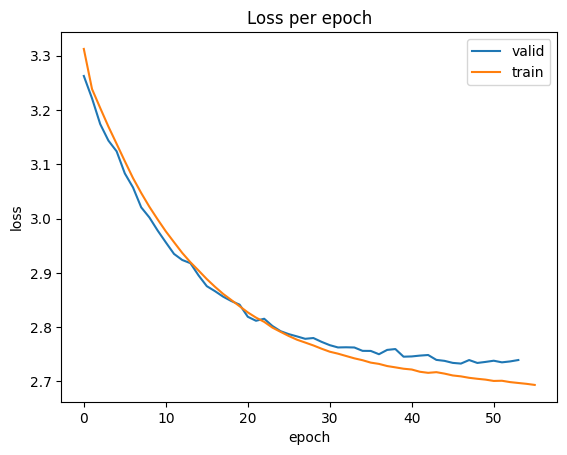

In [ ]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

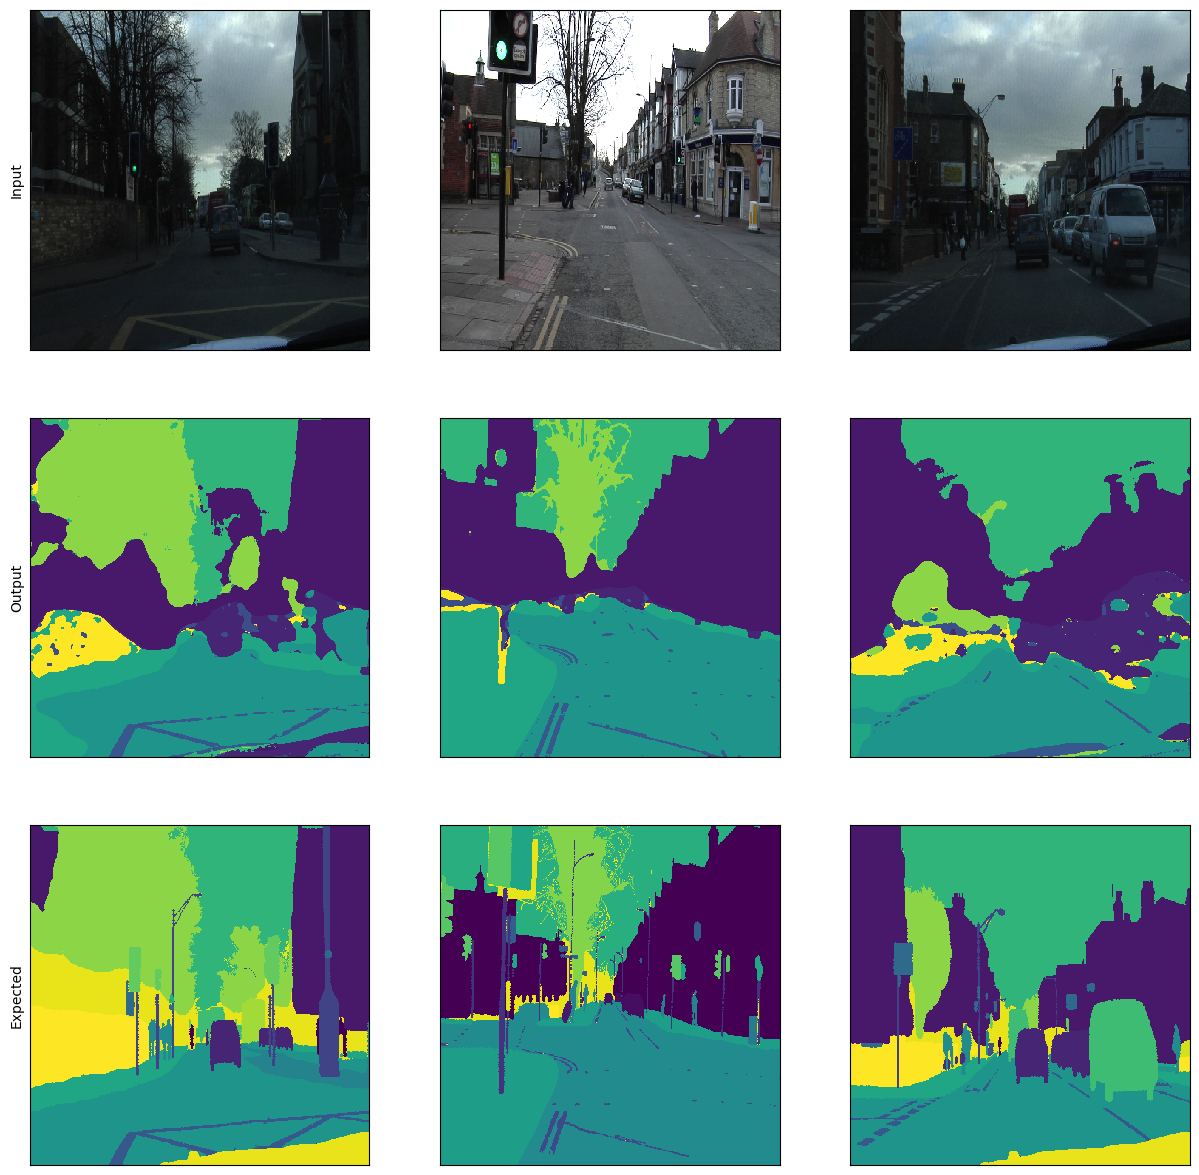

In [7]:
w = 3
fig, ax = plt.subplots(3, w, figsize=(15, 15))

ax[0][0].set_ylabel("Input")
ax[1][0].set_ylabel("Output")
ax[2][0].set_ylabel("Expected")
with torch.no_grad():
    for j in range(w):
        instances, targets = next(iter(test_loader))
        ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
        ax[0][j].set_xticks([])
        ax[0][j].set_yticks([])
        instances = transforms(instances)

        ax[1][j].imshow(torch.argmax(model(instances[0].to(device).unsqueeze(0)).squeeze(0).permute(1, 2, 0), dim=2).cpu().numpy().astype("uint8"), interpolation="None")
        ax[1][j].set_xticks([])
        ax[1][j].set_yticks([])

        ax[2][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
        ax[2][j].set_xticks([])
        ax[2][j].set_yticks([])

In [8]:
from utils.evaluation.multi_channel_iou import IoU
iou = IoU().to(device)

In [9]:
iou_test = torch.zeros([1, 34]).to(device)

for instances, targets in test_loader:
    instances = transforms(instances)
    predict = torch.zeros(targets.shape).to(device)
    res = torch.argmax(model(instances.to(device)), dim=-3)
    for ch in range(targets.shape[1]):
        predict[:, ch, :, :] = (res == ch)
    iou_test += iou(predict, targets.to(device))

iou_test /= len(test_loader)
iou_test

tensor([[3.9119e-01, 6.4528e-01, 9.2641e-01, 7.0996e-01, 3.5276e-02, 6.7100e-01,
         6.2648e-01, 2.7857e-01, 2.0783e-01, 4.0260e-01, 7.5460e-07, 8.7531e-02,
         4.2077e-01, 3.8528e-01, 1.1256e-01, 9.2641e-01, 1.8616e-01, 4.2857e-01,
         9.2150e-03, 8.2381e-01, 5.8874e-01, 5.3508e-01, 1.2121e-01, 8.8813e-01,
         1.2556e-01, 7.8355e-01, 1.7379e-01, 4.7619e-01, 5.4430e-01, 1.1277e-01,
         6.7965e-01, 5.1955e-02, 4.0223e-03, 1.9482e-01]], device='cuda:0')

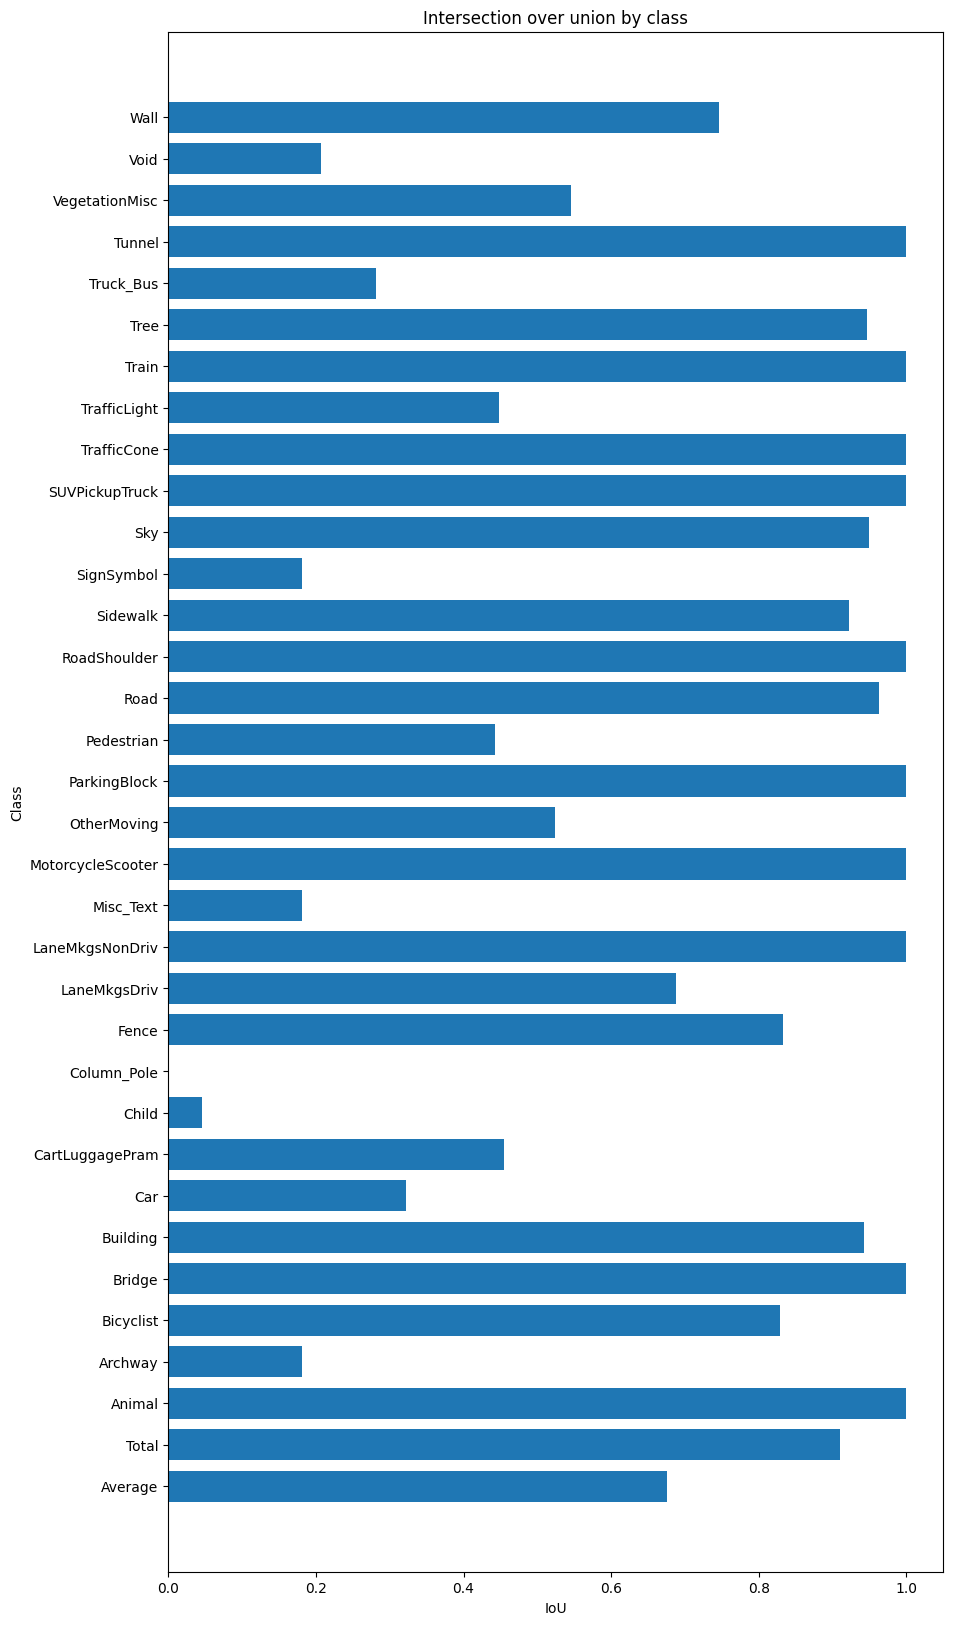

In [44]:
classes = ["Average", "Total", "Animal", "Archway", "Bicyclist", "Bridge", "Building", "Car", "CartLuggagePram", "Child", "Column_Pole", "Fence", "LaneMkgsDriv", "LaneMkgsNonDriv", "Misc_Text", "MotorcycleScooter", "OtherMoving", "ParkingBlock", "Pedestrian", "Road", "RoadShoulder", "Sidewalk", "SignSymbol", "Sky", "SUVPickupTruck", "TrafficCone", "TrafficLight", "Train", "Tree", "Truck_Bus", "Tunnel", "VegetationMisc", "Void", "Wall", ]
values = list(iou_test.squeeze().cpu().numpy())

fig = plt.figure(figsize = (10, 20))

plt.barh(classes, values, height=0.75)
 
plt.xlabel("IoU")
plt.ylabel("Class")
plt.title("Intersection over union by class")
plt.show()

In [46]:
to_save = False

if to_save:
    torch.save(model.state_dict(), r"model\weights\best_pretrained_deconv_road.zip")